<a href="https://colab.research.google.com/github/hhmlai/OpenNMT-tf/blob/master/Create_sat_images_and_green_areas_labels_(with_predict).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook allows (For Sentinel2 or Landsat8 satellite):
1. Receive any coordinate set or place name and get a coordinate set for data download.
2. Change the area of interest interactively with folium
3. Retrieve a geopadas dataframe with a set of polygons or multipolygons of green areas identified in the Open Street Map public database.
4. Retrieve images from earth engine of of Sentinel 2 Satellites with 10m resolution and 4 bands including infrared, of the coordinate set identified on 1, and save as a 4 band TIF file on google drive.
5. Create a mask of 0 and 1 for green areas of the coordinate area identified above and of the dataframe created on 2 or any other geopandas dataframe with a list of polygons identifing green areas and save as a one band TIF file on google drive.

# Data configuration


In [22]:
try:
  import osmnx
  import rasterio
except:
  #install required modules if not previously installed
  !pip install -Uq --no-deps osmnx
  !pip install -Uq rasterio unidecode focal_loss geopandas rtree

import time
import requests
import geopandas as gpd
import folium
from folium.plugins import Draw
import osmnx as ox

import tensorflow as tf
import os
from matplotlib import pyplot as plt
from rasterio.plot import show
import shutil

try:
  import sat_tools2 as st2
#download required files if not done yet
except:
  !wget https://raw.githubusercontent.com/how-green-is-my-city/how-green-is/master/notebooks/sat_tools2.py
  import sat_tools2 as st2

# set place_path as any directory inside Google Drive, to get the satelite images directly from Earth Engine, the place_path  
# These files will presist and be reused if the same area is requested again.
# Remove manualy to save space on Google Drive

place_path = '/content/drive/MyDrive/sat_predict/'

print("Login on Google Drive and Earth Engine") 
print("Required to continue with the demonstration")
st2.gdrive_ee_auth()

Login on Google Drive and Earth Engine
Required to continue with the demonstration
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ee/data.py:219: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.config/earthengine/credentials' mode='r' encoding='UTF-8'>
  tokens = json.load(open(oauth.get_credentials_path()))


In [2]:
# Set a Google Drive directory as the default working directory
# this is a shared drive. First open it in https://drive.google.com/drive/folders/13JGC4DUkh8W6_gy5A3aIkniZlHBBv9PQ?usp=sharing
# then add it to your google drive using add shortcut to my drive
# All the files generate on this notebook will be on this shared drive
# Change to your own private folder if you don't want this behavior   

root_dir = "/content/drive/MyDrive/how-green-is/sentinel2_images/"

personal_dir = root_dir + 'personal/'
sat_data_dir = root_dir + 'places/'

sat_name = "sentinel2"

## 1. Input any place name worldwide and get an area to download

In [3]:
#Create base directory if not existent
st2.force_dirs([place_path], delete_existent=False)

crs_type = 'EPSG:4326'
#Get the city/region to perform the prediction
area_name = None
while area_name is None:
  place_name = input('Any worldwide place to search (as "Paris, France"): ')
  area_name, place_area = st2.get_area(place_name, crs_type)

bounds = place_area.bounds

N_lat = bounds.maxy[0]
S_lat = bounds.miny[0]
W_long = bounds.minx[0]
E_long = bounds.maxx[0]
c_lat, c_long = (N_lat+S_lat)/2,(W_long+E_long)/2

Any worldwide place to search (as "Paris, France"): Ericeira
Got the following place: Ericeira, Mafra, Lisbon, Portugal


# 2. Review and change the area of interest interactively with folium

In [4]:
# to avoid extremmly large files set a maximum area of interest  
max_area = 500e+06 # set the maximum area to get in square meters - to avoid extremly large files

# To measure an area of the map, we need to ensure we are using an equal area projection. 
# For now using one of the recommended on this post: Mollweide Projection (EPSG:54009), but needs further investigation
# https://gis-ops.com/measuring-distances-and-why-projections-matter-practical-examples/  


scale = st2.check_area(place_area, max_area)

print('Review if the selected area is interesting for green label creation. If not, create a new area and use the export button')

m = folium.Map(height=500)
tile = folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True,
        opacity= 0.8
       ).add_to(m)

folium.GeoJson(place_area, style_function=lambda x: {'fillColor': '#00000000'}).add_to(m)
m.add_child(folium.LayerControl())
Draw(
     export=True,
     filename='my_data.geojson',
     position='topleft',
     draw_options={'polyline': {'allowIntersection': False}},
     edit_options={'poly': {'allowIntersection': False}}
).add_to(m)

m.fit_bounds([[N_lat, W_long], [S_lat, E_long]])
m

total area of 12.16 km2
Review if the selected area is interesting for green label creation. If not, create a new area and use the export button


## ONLY RUN CELL BELLOW AFTER COPY THE JSON EXPORTED ABOVE

In [15]:
# OPTIONAL RUN!, if we choose to select a new area of the map

print('DANGER: COPY MANUALLY THE TEXT EXPORTED FROM FOLIUM BEFORE RUN!!!')
res= input('Do you want to change the default OSM area(optional)? (Y/n)')
if res == 'Y':

# PASTE HERE THE TEXT EXPORTED FROM FOLIUM
    geojson = \
{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[2.334824,48.883683],[2.301407,48.86893],[2.322006,48.849656],[2.409897,48.839413],[2.383804,48.888499],[2.334824,48.883683]]]}}]}


    place_area = gpd.GeoDataFrame.from_features(geojson)
    place_area.crs = crs_type
    area_ref = str(place_area.total_bounds).replace(' ','_')[1:-1]
    area_name = area_name[:(80-len(area_ref))]+area_ref
    print('new name:'+area_name)

    bounds = place_area.to_crs('EPSG:4326').bounds

    N_lat = bounds.maxy[0]
    S_lat = bounds.miny[0]
    W_long = bounds.minx[0]
    E_long = bounds.maxx[0]
    c_lat, c_long = (N_lat+S_lat)/2,(W_long+E_long)/2

    scale = st2.check_area(place_area, max_area)

DANGER: COPY MANUALLY THE TEXT EXPORTED FROM FOLIUM BEFORE RUN!!!
Do you want to change the default OSM area(optional)? (Y/n)Y
new name:pred_Paris_Ile-de-France_Metropolitan_Fra_2.301407_48.839413__2.409897_48.888499
total area of 26.90 km2


# Retrieve images from earth engine

In [7]:
year = '2020' #from 2017 up to 2020, if sentinel2 or 2013 to 2020 if landsat8

# Set the folder to save all the images
place_dir = sat_data_dir + area_name +"/"

bounds = list(place_area.total_bounds)
band_sel = ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12')

image_path = st2.image_dowload(sat_data_dir, area_name, year, bounds, crs_type, force_update=False, band_sel=band_sel)
t=0
print("Check progress in tasks where: https://code.earthengine.google.com/")
while not os.path.exists(image_path):
        print("\rWaiting for the files to be downloaded: "+str(t)+"s", end="")
        t=t+1
        time.sleep(1)

st2.crop_area(image_path, place_area.geometry)

File for year 2020 already in cache
Check progress in tasks where: https://code.earthengine.google.com/


# 4. Retrieve a geopandas dataframe with a set of polygons or multipolygons of green areas identified in the Open Street Map public database

In [8]:
# selected the OSM tags considered as green, but can be reviewed)
tags_green_natural =  {'natural': ['tree', 'wood', 'scrub', 'wetland', 'grassland', 'tree_row', 'heath', 'fell', 'shrub', 'grass', 'forest', 'bush']}
    #see:  https://wiki.openstreetmap.org/wiki/Key:natural
tags_green_landuse =  {'landuse': ['farmland', 'forest',  'grass', 'meadow', 'orchard', 'farmyard', 'vineyard', 'allotments', 'recreation_ground', 'village_green', 'plant_nursery', 'farm', 'flowerbed', 'plantation', 'agriculture', 'garden', 'cemetery']}
    #see:  https://wiki.openstreetmap.org/wiki/Key:landuse
tags_green_leisure = {'leisure': ['garden', 'golf_course', 'nature_reserve', 'park', 'common', 'pitch']}
    #see:  https://wiki.openstreetmap.org/wiki/Key:leisure

green_tags = {**tags_green_natural, **tags_green_landuse, **tags_green_leisure}

print('please wait while I get the green areas tagged in ' + area_name)
print('It can take some time... ')
# get dataframe of green areas from the defined place 
green_areas = ox.geometries.geometries_from_bbox(N_lat, S_lat, E_long, W_long, green_tags)
green_areas.crs = crs_type
# green_areas = ox.geometries_from_place(place_name, green_tags).to_crs(crs=crs_type)

# greens_df will collect all the green areas/points of the place 
greens_df = gpd.GeoDataFrame(columns=['name','geometry'])
for area_type  in green_tags:
  for area in green_tags[area_type]:
    if area_type in green_areas.columns:
      sub_df = green_areas[green_areas[area_type]==area][['geometry']]
      sub_df['name'] = green_areas[green_areas[area_type]==area][area_type]
      greens_df = greens_df.append(sub_df)

greens_df = greens_df.loc[greens_df.geometry.geom_type.isin(['Polygon','MultiPolygon'])].to_crs(crs=crs_type)

# Subtract green areas outside place area
greens_df = gpd.overlay(place_area, greens_df, how='intersection')

print(greens_df.total_bounds)

#new_df = greens_df.groupby(['name']).count()
#set minimum number of class samples in order be considerer for classification 
#min_count_learning = 50
#new_index = new_df[new_df.geometry.gt(min_count_learning)].index.values
#greens_df = greens_df.loc[greens_df['name'].isin(new_index)]

greens_df.to_csv(place_dir + 'green_areas.csv')

please wait while I get the green areas tagged in pred_Ericeira_Mafra_Lisbon_Portugal
It can take some time... 
[-9.4221041  38.95275973 -9.38545084 38.99003465]


### Create a mask of 0 and 1 for green areas of the coordinate area 

Values in labeled image:  [0 1]


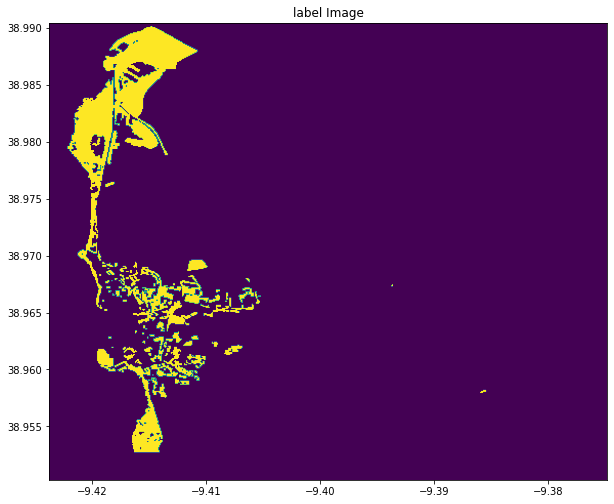

In [9]:
# In alternative to the OSM data, is possible load any geoDataFrame in csv. 
# Required a 'name' column identifing the class of green area (by default assumed only one class, so this is ignored) 
# and a 'geometry' column with shapely polygons or multipolygons of the green area 

#place_dir = sat_data_dir + area_name +"/"
#greens_df = gpd.GeoDataFrame(pd.read_csv(place_dir+'/green_areas.csv'))
#greens_df.crs = crs_type

# get the file and labels file as a CSV table with name an  

classes = greens_df.name.unique()

n_classes = len(classes)
# set all classes to the same label of 1 
class_dict = dict(zip(classes, [1 for i in range(n_classes)]))

# uncomnent to use each class label label (max 255 classes)  
# class_dict = dict(zip(classes, [i for i in range(n_classes[:256])]))

# convert string geometries to shapely geometries 
#greens_df['geometry'] = greens_df['geometry'].apply(loads)

# burn the labels on labels.tiff file in given dir using the same properties of sat image
labels_file = place_dir + '/labels.tif'
with rasterio.open(image_path) as src:
  st2.save_label(greens_df, src.profile, labels_file, class_dict)

#view the final result
with rasterio.open(labels_file) as labels:
    plt.figure(figsize=(10, 15))
    plt.title("label Image")  
    show(labels)  

# Create tiles for prediction

In [13]:
# If running this cell alone set the place_dir and year here:

#place_dir = '/content/drive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Zurich_District_Zurich_Zurich_Switzerland/'
#year = '2020'

tile_shape = [224,224,3]
label_shape = [224,224,1]

height, width, channels = tile_shape[0],tile_shape[1],tile_shape[2]
force_img_update = True

origin_file = place_dir + 'image_'+year+'.tif'
true_file = place_dir + 'labels.tif'
stack_file = place_dir + year + ' _stack.tif'

with rasterio.open(origin_file) as src:
  stack = st2.bandstack(src.read(4), src.read(3), src.read(1)) 
  meta = src.meta

st2.save_stack(stack, stack_file, src, channels, force_img_update)

with rasterio.open(stack_file) as stack:
  st2.tile_img(stack, place_dir + 'tiles/imgs_' + year + '/', tile_shape , 'uint16')

with rasterio.open(true_file) as label:
  st2.tile_img(label, place_dir + 'tiles/labels/', label_shape, 'uint8')


# 5. Predict the new labels

In [15]:
output_file = place_dir + year + '_predict.tif'
    
save_model_path = root_dir + 'model_out/best_model_unet.h5'
model = tf.keras.models.load_model(save_model_path)

st2.predict_with_tile(stack_file, output_file, model, tile_shape=tile_shape)

Performing the prediction
tmp_tiles/


0.28378656354136667

In [20]:
# Final review of the labels over detailed sat images
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
preview_files = [(year, stack_file, output_file)]
m = st2.folium_preview(stack_file, preview_files, show_lst=[2020], place_area=place_area)
m

loading prediction image for year 2020


# Delete the files ONLY if you don't like the result

In [21]:
# place_dir = '/content/gdrive/MyDrive/how-green-is/landsat8_images/places/Zurich_District_Zurich_Zurich_Switzer_8.416901_47.303913__8.758163_47.487977'
print(place_dir)
res = input("do you want to delete ALL place_area directory? (Y/n):")
if res == 'Y':
  shutil.rmtree(place_dir)

/content/drive/MyDrive/how-green-is/sentinel2_images/places/pred_Ericeira_Mafra_Lisbon_Portugal/
do you want to delete ALL place_area directory? (Y/n):Y


NameError: ignored